In [1]:
!pip install torchtext==0.6.0 --quiet
!pip3 install pytorch_lightning --quiet
!pip install keybert --quiet
!pip install keytotext --quiet

In [2]:
!wget -O train_data1.pkl https://rice.box.com/shared/static/n3nwtgm7a2952fzjq7y5c8fdqbpxlfav.pkl 
!wget -O train_data2.pkl https://rice.box.com/shared/static/xtnl2yyyjnqzsqkklxzm3upm9hvc7rfx.pkl 
!wget -O train_data3.pkl https://rice.box.com/shared/static/6vgxpyvhxrrmakjs6m4jt35r6o20hd2c.pkl 
!wget -O train_data4.pkl https://rice.box.com/shared/static/9qjcfo0p71goy286chr6doni9ipws98u.pkl 
!wget -O train_data5.pkl https://rice.box.com/shared/static/yv4fnez0f6kl6a3w8ormn8x3pmwcg1dq.pkl 
!wget -O val_data.pkl https://rice.box.com/shared/static/1pklsm6vba55ofx8jip3idlllnttir33.pkl

--2022-04-29 21:22:56--  https://rice.box.com/shared/static/n3nwtgm7a2952fzjq7y5c8fdqbpxlfav.pkl
Resolving rice.box.com (rice.box.com)... 185.235.236.197
Connecting to rice.box.com (rice.box.com)|185.235.236.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/n3nwtgm7a2952fzjq7y5c8fdqbpxlfav.pkl [following]
--2022-04-29 21:22:57--  https://rice.box.com/public/static/n3nwtgm7a2952fzjq7y5c8fdqbpxlfav.pkl
Reusing existing connection to rice.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://rice.app.box.com/public/static/n3nwtgm7a2952fzjq7y5c8fdqbpxlfav.pkl [following]
--2022-04-29 21:22:58--  https://rice.app.box.com/public/static/n3nwtgm7a2952fzjq7y5c8fdqbpxlfav.pkl
Resolving rice.app.box.com (rice.app.box.com)... 103.116.4.201
Connecting to rice.app.box.com (rice.app.box.com)|103.116.4.201|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl2.boxcloud

In [2]:
import torch
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import json
import torchtext
import pandas, os, pickle
from tqdm.notebook import tqdm
from PIL import Image
from torch.utils.data.dataset import Dataset
from torch.nn.utils.rnn import pad_sequence
import requests
from io import BytesIO
import torchvision
import torchvision.transforms as transforms
from keybert import KeyBERT

# Plot the image.
def display_image(img):
  plt.figure(); plt.imshow(img)
  plt.grid(False);  plt.axis('off'); plt.show()

class CategoryDataset(torch.utils.data.Dataset):
    def __init__(self, tokenizer, 
                 filenames: [], # location of the file.
                 build_vocab = True,
                 vocabulary_size = 12000, 
                 prev_texts = [],
                 start = 0,
                 end = 7000):

      self.texts = []
      self.images = []
      self.og_captions = []
      self.url = []
      self.keywords = []
      self.tokenized_keywords = []
      self.build_vocab = build_vocab
      self.textTokenizer = tokenizer
      keyword_model = KeyBERT()
      
      for filename in filenames: 

        print('Loading %s ...\n' % filename, end = '')

        with open(filename, 'rb') as f:
          temp_data = pickle.load(f)

        print("Pickle File Loaded")
        
        if (start != 0 or end != 7000):
          for i in tqdm(range(start, min(len(temp_data), end))):
            self.texts.append(tokenizer.preprocess(temp_data[i][0]))
            self.og_captions.append(temp_data[i][0])
            self.url.append(temp_data[i][1])
            self.images.append(temp_data[i][2])

            keywords = keyword_model.extract_keywords(temp_data[i][0])
            keyword_text = ""

            for elem in keywords:
              keyword_text = keyword_text + str(elem[0]) + " "

            self.keywords.append(keyword_text)
            self.tokenized_keywords.append(tokenizer.preprocess(keyword_text))

            keywords = list()
            token_keywords = list()
            
            temp_data[i] = None
          
          temp_data = list()

          print("\n")
        else :
          for i in tqdm(range(0, len(temp_data))):
            self.texts.append(tokenizer.preprocess(temp_data[i][0]))
            self.og_captions.append(temp_data[i][0])
            self.url.append(temp_data[i][1])
            self.images.append(temp_data[i][2])

            keywords = keyword_model.extract_keywords(temp_data[i][0])
            keyword_text = ""

            for elem in keywords:
              keyword_text = keyword_text + str(elem[0]) + " "

            self.keywords.append(keyword_text)
            self.tokenized_keywords.append(tokenizer.preprocess(keyword_text))

            keywords = list()
            token_keywords = list()
            
            temp_data[i] = None
          
          temp_data = list()

          print("\n")

      if self.build_vocab:
        tokenizer.build_vocab(self.tokenized_keywords + self.tokenized_keywords + self.texts, max_size = vocabulary_size)

      # print(self.keywords[1])

      # for elem in self.keywords[1]:
      #   print(elem)
      #   print(self.textTokenizer.vocab.stoi[elem])
     

      for i in tqdm(range(0 , len(self.texts))):
        self.texts[i] = tokenizer.process([self.texts[i]])
        self.tokenized_keywords[i] = tokenizer.process([self.tokenized_keywords[i]])

        
    def __len__(self):
        return len(self.texts)
  
    def __getitem__(self, i):
        return self.images[i], self.tokenized_keywords[i].squeeze()
    
    def get_original_caption(self, i):
      return self.og_captions[i]
    
    def get_url(self, i):
      return self.url[i]
    
    def get_keywords(self, i):
      return self.keywords[i]
    
    def get_tokenized_keywords(self, i):
      return self.tokenized_keywords[i]
    
    # To be used in the Data Loader collate_fn parameter.
    def create_batch(self, batch):
        images, keywords = zip(*batch)

        # Compute text lengths for Pytorch's RNN library.
        keywords_lengths = [len(keyword) for keyword in keywords]

        # Stack images and pad text.
        stacked_images = torch.stack(images)
        padded_keywords = pad_sequence(keywords, batch_first = self.textTokenizer.batch_first, 
                                    padding_value = self.textTokenizer.vocab.stoi["<pad>"])

        return stacked_images, padded_keywords, keywords_lengths

In [6]:
textTokenizer = torchtext.data.Field(sequential = True,
                                            init_token = "<start>", eos_token = "<end>", 
                                            pad_token = "<pad>", unk_token = "<unk>",
                                            batch_first = True)

In [7]:
filenames = []
#filenames.append("/content/small_data.pkl")
filenames.append("/content/train_data1.pkl")
filenames.append("/content/train_data2.pkl")
filenames.append("/content/train_data3.pkl")
filenames.append("/content/val_data.pkl")
filenames.append("/content/train_data5.pkl")

train_set = CategoryDataset(tokenizer = textTokenizer, filenames = filenames)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Loading /content/train_data1.pkl ...
Pickle File Loaded


  0%|          | 0/4998 [00:00<?, ?it/s]



Loading /content/train_data2.pkl ...
Pickle File Loaded


  0%|          | 0/4998 [00:00<?, ?it/s]



Loading /content/train_data3.pkl ...
Pickle File Loaded


  0%|          | 0/4998 [00:00<?, ?it/s]



Loading /content/val_data.pkl ...
Pickle File Loaded


  0%|          | 0/6111 [00:00<?, ?it/s]



Loading /content/train_data5.pkl ...
Pickle File Loaded


  0%|          | 0/4998 [00:00<?, ?it/s]

  0%|          | 0/26103 [00:00<?, ?it/s]

In [8]:
val_set = CategoryDataset(tokenizer = textTokenizer, filenames = ["/content/train_data4.pkl"], build_vocab = False, start = 0, end = 2000)

Loading /content/train_data4.pkl ...
Pickle File Loaded


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [5]:
test_set = CategoryDataset(tokenizer = altTextTokenizer, filenames = ["/content/train_data4.pkl"], build_vocab = False, start = 3000, end = 4000)

Loading /content/train_data4.pkl ...
Pickle File Loaded


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
# Now to data loaders and batch building.
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size = 128, 
                                           num_workers = 4,
                                           shuffle = True,
                                           collate_fn = train_set.create_batch)
val_loader = torch.utils.data.DataLoader(val_set, 
                                         batch_size = 128, 
                                         num_workers = 4,
                                         shuffle = False,
                                         collate_fn = val_set.create_batch)
(images, keywords, keyword_lengths) = next(iter(val_loader))

print(images.shape, keywords.shape, len(keyword_lengths))

torch.Size([128, 3, 224, 224]) torch.Size([128, 7]) 128


In [6]:
import torch.nn as nn
import torchvision.models as models

class ImageEncoder(nn.Module):
    # Encode images using Resnet-152
    def __init__(self, encoding_size: int):
        super(ImageEncoder, self).__init__()
        self.base_network = models.resnet152(pretrained = True)
        self.base_network.fc = nn.Linear(self.base_network.fc.in_features, encoding_size)
        self.bn = nn.BatchNorm1d(encoding_size, momentum=0.01)
        self.init_weights()

    def init_weights(self):
        
        self.base_network.fc.weight.data.normal_(0.0, 0.02)
        self.base_network.fc.bias.data.fill_(0)

    def forward(self, image):

        with torch.no_grad():

            x = self.base_network.conv1(image)
            x = self.base_network.bn1(x)
            x = self.base_network.relu(x)
            x = self.base_network.maxpool(x)
          
            x = self.base_network.layer1(x)
            x = self.base_network.layer2(x)
            x = self.base_network.layer3(x)
            x = self.base_network.layer4(x)
          
            x = self.base_network.avgpool(x)
            x = torch.flatten(x, 1)
  
        featureMap = self.base_network.fc(x)
        featureMap = self.bn(featureMap)
        return featureMap

In [ ]:
image_encoder = ImageEncoder(1024)
image_encoder.eval()
encoded_images = image_encoder(images[0][None, :])
print(encoded_images.shape)
images[0][None, :].size()

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

torch.Size([1, 1024])


torch.Size([1, 3, 224, 224])

In [7]:
import torch.nn as nn
from torch.nn import functional as F


class TextDecoder(nn.Module):
    def __init__(self, input_size: int, state_size: int, vocab_size: int):
        super(TextDecoder, self).__init__()
        self.state_size = state_size
        self.embedding = nn.Embedding(vocab_size, input_size)
        self.rnnCell = nn.LSTMCell(input_size, state_size, bias=True)
        self.predictionLayer = nn.Linear(state_size, vocab_size)
        self.init_weights()
        
    def dummy_input_state(self, batch_size ):

        return (torch.zeros(batch_size, self.state_size), torch.zeros(batch_size, self.state_size))
    
    def init_weights(self):
        
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.predictionLayer.bias.data.fill_(0)
        self.predictionLayer.weight.data.uniform_(-0.1, 0.1)
        
    def forward(self, input_state, current_token_id):
        # Embed the input token id into a vector.
        embedded_token = self.embedding(current_token_id)

        # Pass the embedding through the RNN cell.
        h,c = self.rnnCell(embedded_token, input_state)
        
        # Output prediction.
        prediction = self.predictionLayer(F.relu(h))
        
        return prediction, (h,c)

In [ ]:
# Example usage.
text_decoder = TextDecoder(512, 1024, len(textTokenizer.vocab))

# Pick the first token of the text batch (after the <start> token).
sample_input_token = keywords[0][None, :][:, 1]
batch_size = keywords[0][None, :].shape[0]
initial_state = text_decoder.dummy_input_state(batch_size)

print(initial_state[0].size())

# Compute prediction in current time step and state vector for next time step.
prediction, output_state = text_decoder(initial_state, sample_input_token)

# Print the shape of the next token prediction (for each sequence in the batch)
print("next token prediction: ", prediction.shape)

torch.Size([1, 1024])
next token prediction:  torch.Size([1, 12004])


In [8]:
import random 
import pytorch_lightning as pl

# Image Captioning module.
# Using pytorch-lightning for simplicity.

class ImageCaptioner(pl.LightningModule):
    def __init__(self, textTokenizer, val_data = None, embedding_size = 512, state_size = 1024):
        super(ImageCaptioner, self).__init__()
        self.vocabulary_size = len(textTokenizer.vocab)
        self.padding_token_id = textTokenizer.vocab.stoi["<pad>"]

        
        self.val_data = val_data
        
        
        # Create image encoder and text decoder.
        self.image_encoder = ImageEncoder(state_size)
        self.text_decoder = TextDecoder(embedding_size, 
                                        state_size, 
                                        self.vocabulary_size)
        
        self.criterion = nn.CrossEntropyLoss(
            ignore_index = self.padding_token_id)
        
        self.init_image_transforms()
        self.text_tokenizer = textTokenizer

        self.image_encoder_learning_rate = 1e-4
        self.text_decoder_learning_rate = 1e-3
    
    def init_image_transforms(self):
        # Create image transforms using standard Imagenet-based model transforms.
        normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                         std = [0.229, 0.224, 0.225])
        
        self.image_train_transform = \
            transforms.Compose([transforms.Resize(256),
                                transforms.RandomCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                normalize])
        
        self.image_test_transform = \
            transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                normalize])

    # Predict text given image -- input text is for "teacher forcing" only.
    def forward(self, image, text, lengths, teacher_forcing = 1.0):
        # Keep output scores for tokens in a list.
        predicted_scores = list()
        
        # Encode the image.
        encoded_image = self.image_encoder(image)
        
        # Grab the first token in the sequence.
        start_token = text[:, 0]  # This should be the <start> symbol.
        
        # Predict the first token from the start token embedding 
        # and feed the image as the initial state.
        # let first input state = None
        token_scores, state = self.text_decoder((encoded_image,encoded_image), start_token)
        predicted_scores.append(token_scores)
        
        # Iterate as much as the longest sequence in the batch.
        # minus 1 because we already fed the first token above.
        # minus 1 because we don't need to feed the end token <end>.
        for i in range(0, max(lengths) - 2):
            if random.random() < teacher_forcing:
                current_token = text[:, i + 1]
            else:
                _, max_token = token_scores.max(dim = 1)
                current_token = max_token.detach() # No backprop.
            token_scores, state = self.text_decoder(state, current_token)
            predicted_scores.append(token_scores)
            
        # torch.stack(,1) forces batch_first = True on this output.
        return torch.stack(predicted_scores, 1), lengths

    def training_step(self, batch, batch_idx, optimizer_idx):
        images, texts, lengths = batch

        # Compute the predicted texts.
        predicted_texts, _ = self(images, texts, lengths, 
                                  teacher_forcing = 1.0)        

        # Define the target texts. 
        # We have to predict everything except the <start> token.
        target_texts =  texts[:, 1:].contiguous()

        # Use cross entropy loss.
        loss = self.criterion(predicted_texts.view(-1, self.vocabulary_size),
                              target_texts.view(-1))
        self.log('train_loss', loss, on_epoch = True)
        return {'loss': loss}

    def validation_step(self, batch, batch_idx):
        images, texts, lengths = batch

        predicted_texts, _ = self(images, texts, lengths,
                                  teacher_forcing = 0.0)
        
        target_texts = texts[:, 1:].contiguous()

        loss = self.criterion(predicted_texts.view(-1, self.vocabulary_size),
                              target_texts.view(-1))
        self.log('val_loss', loss, on_epoch = True)
        return {'val_loss': loss}

    def validation_epoch_end(self, outputs):
        loss_mean = torch.stack([x['val_loss'] for x in outputs]).mean()
        print('Validation loss %.2f' %  loss_mean)
        
        return {'val_loss': loss_mean}
    
    def training_epoch_end(self, outputs):
        print(outputs[0])
        loss_mean = torch.stack([x['loss'] for x in outputs[0]]).mean()
        print('Training loss %.2f' %  loss_mean)


    def configure_optimizers(self):
        return [torch.optim.SGD(list(self.image_encoder.base_network.fc.parameters())+\
                                list(self.image_encoder.bn.parameters()),
                                lr = self.image_encoder_learning_rate), \
                torch.optim.Adam(self.text_decoder.parameters(), 
                                 lr = self.text_decoder_learning_rate)], []

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    filename = 'checkpoints/image_captioner_weights_{epoch:03d}-{val_loss:.2f}',
    verbose = True, monitor = 'val_loss', mode = 'min', save_top_k = 1)

# # Create image captioner.
image_captioner = ImageCaptioner(textTokenizer)

# # Simple thanks to Pytorch Lighting.
trainer = pl.Trainer(gradient_clip_val = 1.0, gpus = 1, 
                     min_epochs = 5, max_epochs = 10,
                     callbacks = [checkpoint_callback],
                     enable_model_summary = False) 

# # Train the model.
trainer.fit(image_captioner, 
            train_dataloaders = train_loader, 
            val_dataloaders = [val_loader]) 

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /content/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/data.py:73: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 128. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"


Validation loss 9.40


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/data.py:73: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 119. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"


Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/data.py:73: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 80. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"
Epoch 0, global step 408: 'val_loss' reached 5.65795 (best 5.65795), saving model to '/content/lightning_logs/version_0/checkpoints/checkpoints/image_captioner_weights_epoch=000-val_loss=5.66.ckpt' as top 1


Validation loss 5.66
[{'loss': tensor(9.4098, device='cuda:0')}, {'loss': tensor(9.4098, device='cuda:0')}]
Training loss 9.41


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 816: 'val_loss' reached 5.64680 (best 5.64680), saving model to '/content/lightning_logs/version_0/checkpoints/checkpoints/image_captioner_weights_epoch=001-val_loss=5.65.ckpt' as top 1


Validation loss 5.65
[{'loss': tensor(5.5279, device='cuda:0')}, {'loss': tensor(5.5279, device='cuda:0')}]
Training loss 5.53


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 1224: 'val_loss' was not in top 1


Validation loss 5.90
[{'loss': tensor(4.6100, device='cuda:0')}, {'loss': tensor(4.6099, device='cuda:0')}]
Training loss 4.61


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 1632: 'val_loss' was not in top 1


Validation loss 6.25
[{'loss': tensor(3.3495, device='cuda:0')}, {'loss': tensor(3.3493, device='cuda:0')}]
Training loss 3.35


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 2040: 'val_loss' was not in top 1


Validation loss 6.56
[{'loss': tensor(2.4396, device='cuda:0')}, {'loss': tensor(2.4394, device='cuda:0')}]
Training loss 2.44


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 2448: 'val_loss' was not in top 1


Validation loss 6.89
[{'loss': tensor(1.9061, device='cuda:0')}, {'loss': tensor(1.9059, device='cuda:0')}]
Training loss 1.91


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 2856: 'val_loss' was not in top 1


Validation loss 7.19
[{'loss': tensor(1.5192, device='cuda:0')}, {'loss': tensor(1.5189, device='cuda:0')}]
Training loss 1.52


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 3264: 'val_loss' was not in top 1


Validation loss 7.42
[{'loss': tensor(1.1121, device='cuda:0')}, {'loss': tensor(1.1119, device='cuda:0')}]
Training loss 1.11


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 3672: 'val_loss' was not in top 1


Validation loss 7.60
[{'loss': tensor(0.7455, device='cuda:0')}, {'loss': tensor(0.7454, device='cuda:0')}]
Training loss 0.75


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 4080: 'val_loss' was not in top 1


Validation loss 7.80
[{'loss': tensor(0.5180, device='cuda:0')}, {'loss': tensor(0.5178, device='cuda:0')}]
Training loss 0.52


In [10]:
# Load the pre-trained model
checkpoint = torch.load("/content/model_checkpoint.ckpt")
image_captioner1 = ImageCaptioner(altTextTokenizer)
image_captioner1.load_state_dict(checkpoint['state_dict'])

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

<All keys matched successfully>

In [19]:
  # Write a function to generate captions

def generate_caption(model, image, max_length = 15):

    # Set the starting text with just the start token
    text = "<start>"

    # We evaluate the model in order to get it started
    model.eval()

    # After initializing the transforms, we can apply them to our image
    model.init_image_transforms()
    image = model.image_test_transform(image)
    image = image[None, :]

    # Create a text_tensor which can be used for the model
    text_tensor = torch.tensor([altTextTokenizer.vocab.stoi["<start>"]]).unsqueeze(0);

    # Run the model and change the results to a desirable format
    predicted_scores, _ = model(image, text_tensor, [max_length], 0)
    predicted_scores = predicted_scores[0, :, :].detach().softmax(dim = 1)
    predicted_scores = predicted_scores.view(-1, model.vocabulary_size)

    # Choose the tokens with the highest prediction score
    _, max_token = predicted_scores.max(dim = 1)

    # Get started on creating a text from these tokens and stop when we hit an 
    # <end> token
    final_text = ""

    for id in max_token:
      final_text += " "
      final_text += altTextTokenizer.vocab.itos[id]
      if altTextTokenizer.vocab.itos[id] == "<end>":
        break

    return final_text

In [ ]:
from keytotext import pipeline
nlp = pipeline("k2t-base")  #loading the pre-trained model
params = {"do_sample":True, "num_beams":4, "no_repeat_ngram_size":3, "early_stopping":True}

Global seed set to 42


Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

In [ ]:
for i in range(10,20):
    print(i)
    url = val_set.get_url(i)
    _ , text = val_set[i]
    img = Image.open(BytesIO(requests.get(url).content))
    caption = generate_caption(image_captioner1, img)

    print(caption)
    print(val_set.get_keywords(i))

    # caption = caption + " "  + val_set.get_keywords(i)

    keywords = caption.split(' ')
    keywords = keywords[0:-1]
    keywords = keywords + val_set.get_keywords(i) .split(" ")

    keys = []
    for word in keywords:
      if word != '' and word != '<unk>' and word != 'cat':
        keys.append(word)

    keys = keys[:4]
    print(keys)

    display_image(img)

    
    #decoding params
    actual_caption = (nlp(keys, **params))
    
    print("Predicted: {}".format(actual_caption))
    print("True: {}".format(" ".join([image_captioner.text_tokenizer.vocab.itos[c]
                             for c in text.tolist()])))

In [ ]:
  # Write a function to generate captions

def alt_generate_caption(model, image, max_length = 15):

    # Set the starting text with just the start token
    text = "<start>"

    # We evaluate the model in order to get it started
    model.eval()

    # After initializing the transforms, we can apply them to our image
    model.init_image_transforms()
    image = model.image_test_transform(image)
    image = image[None, :]

    # Create a text_tensor which can be used for the model
    text_tensor = torch.tensor([textTokenizer.vocab.stoi["<start>"]]).unsqueeze(0);

    # Run the model and change the results to a desirable format
    predicted_scores, _ = model(image, text_tensor, [max_length], 0)
    predicted_scores = predicted_scores[0, :, :].detach().softmax(dim = 1)
    predicted_scores = predicted_scores.view(-1, model.vocabulary_size)

    # Choose the tokens with the highest prediction score
    # _, max_token = predicted_scores.max(dim = 1)

    # Get started on creating a text from these tokens and stop when we hit an 
    # <end> token
    final_text = ""

    for prediction in predicted_scores:
      id = np.random.choice(len(prediction), p = prediction.numpy())
      final_text += " "
      final_text += textTokenizer.vocab.itos[id]
      if textTokenizer.vocab.itos[id] == "<end>":
        break

    return final_text

In [ ]:
def create_caption(url, input_words):

    img = Image.open(BytesIO(requests.get(url).content))
    caption = generate_caption(image_captioner1, img)

    print("Caption from CNN: ", caption)

    keywords = input_words.split(' ') + caption.split(' ')[1:-1]
    print("Keywords: ", keywords)

    keys = []
    for word in keywords:
      if word != '<unk>' and word != 'cat':
        keys.append(word)
    print("Keys: ", keys)

    display_image(img)

    
    #decoding params
    actual_caption = (nlp(keys, **params))
    
    print("Predicted: {}".format(actual_caption))

Caption from CNN:   <unk> <end>
Keywords:  ['Cat', '<unk>']
Keys:  ['Cat']


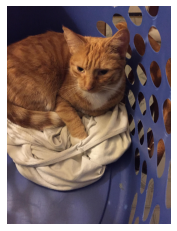

Predicted: Cat is a Cat.


In [ ]:
create_caption("https://i.redd.it/jmgo63dbxp721.jpg", "Cat")

In [ ]:
for i in range(0,10):
    print(i)
    url = val_set.get_url(i)
    _ , text = val_set[i]
    img = Image.open(BytesIO(requests.get(url).content))
    caption = alt_generate_caption(image_captioner, img)

    print(caption)
    print(val_set.get_keywords(i))

    # caption = caption + " "  + val_set.get_keywords(i)

    keywords = caption.split(' ')
    keywords = keywords[1:-1]
    keywords = keywords + val_set.get_keywords(i) .split(" ")
    keywords = keywords[:4]
    print(keywords)

    keys = []
    for word in keywords:
      if word != '<unk>' and word != 'cat':
        keys.append(word)

    display_image(img)

    
    #decoding params
    actual_caption = (nlp(keys, **params))
    
    print("Predicted: {}".format(actual_caption))
    print("True: {}".format(" ".join([image_captioner.text_tokenizer.vocab.itos[c]
                             for c in text.tolist()])))